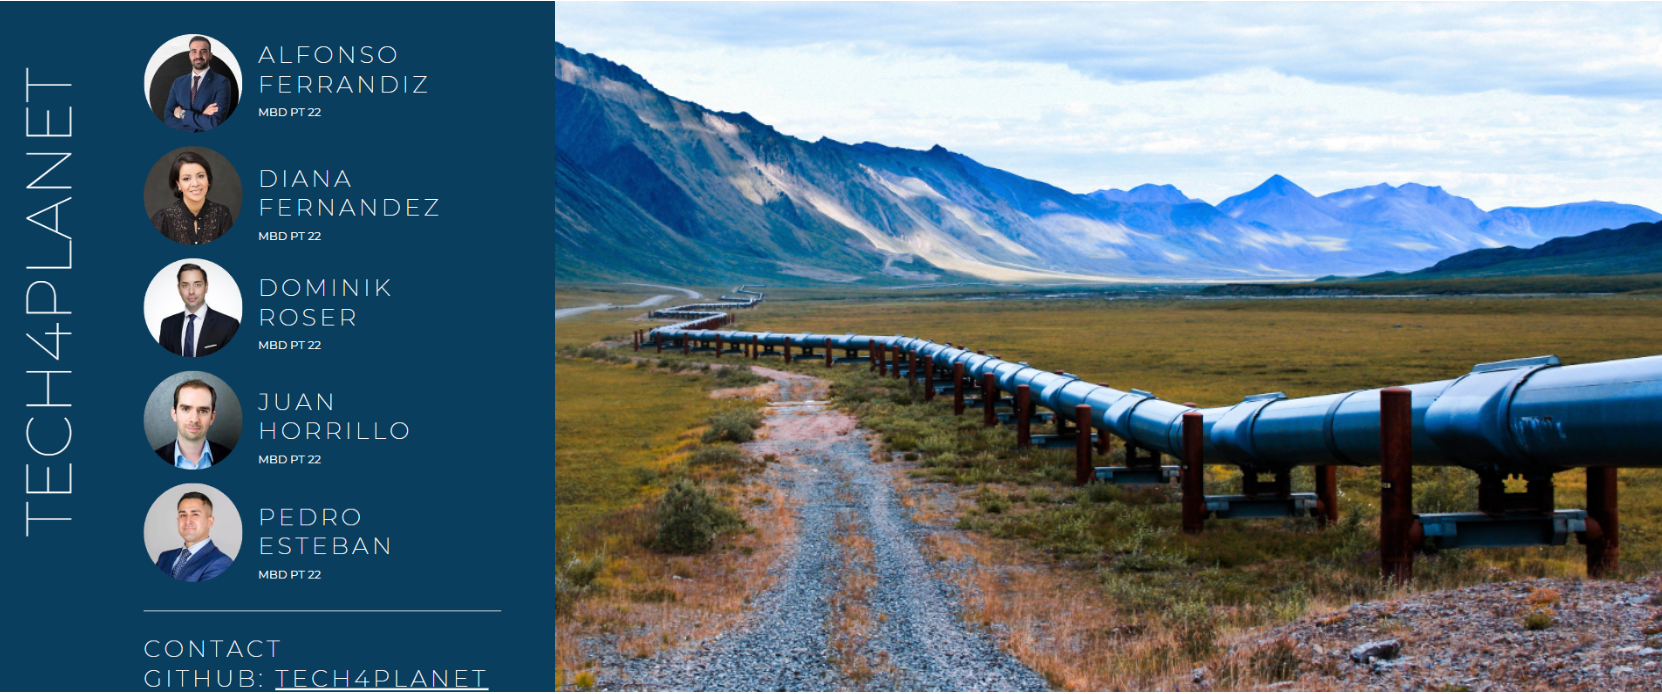

# A Business Case for Predictive Pipeline Maintenance

## IE Sustainability Datathon 2023

### Tech4Planet: https://github.com/orgs/tech4plannet/


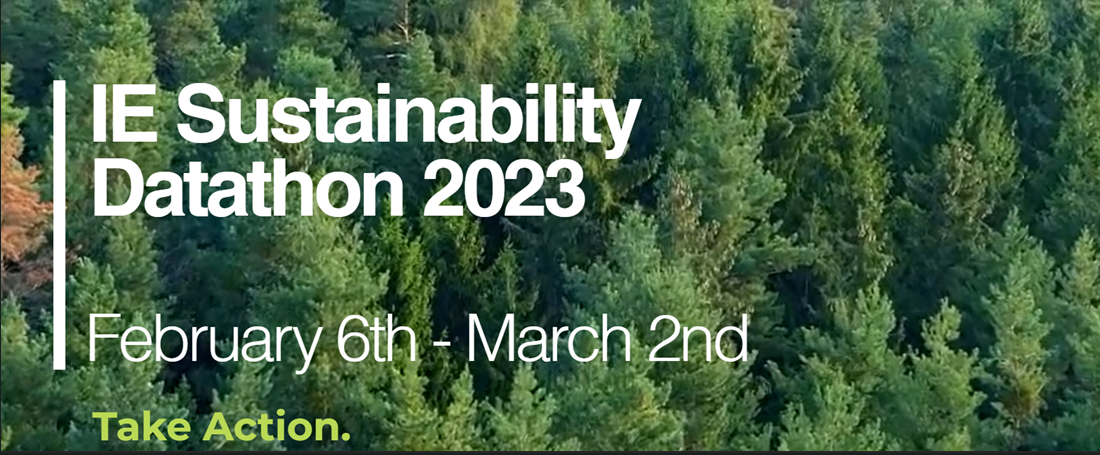

### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Structure of these series of Jupyter Notebooks
### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### 1. EDA

### 2. Inspection Strategy

### 3. Feature Engineering

### 4. Data Wrangling and Outliers

### 5. Baseline Models

### 6. Fine Tuning and Hyperparameter Tuning


### ==========================================================================
## You are in Notebook 2: Inspection Strategy
### ==========================================================================


# <font color=green> Table of contents </font>

* [__1. Libraries Used__](#1)  
* [__2. Merging__](#2)  
* [__3. Parameter Definition__](#3)  
* [__4. Scenarios__](#4)  

<a id='1'></a>
# <font color=green> 1. Libaries used </font>

In [5]:
#IMPORT Libaries
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import os

<a id='2'></a>
# <font color=green> 2. Merging </font>

In [ ]:
# create a dataframe for the pipedata

#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon\base\complementary_datasets")

df_network = pd.read_csv("df_submission1.csv") #909733 rows

df_inspection = pd.read_csv("inspections.csv") #6345344 rows

df = pd.merge(df_inspection, df_network, on="PipeId")


In [ ]:
#import failure probabilities for occurance from prediction model

df_prob  = pd.read_csv("probablity.csv") #909733 rows

df = pd.merge(df, df_prob, on="PipeId")

df = df.rename(columns={"Incidence_y": "prob"})

df.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence_x,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,prob
0,188889914,ZRV-00001406,2010,2010-10-01,22,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.000285
1,188889914,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.000285
2,188889914,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.000285
3,188889914,ZRV-00001406,2015,2015-11-06,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.000285
4,188889914,ZRV-00001406,2017,2017-11-25,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.000285


In [9]:
#define the sample size for the runthrough

#variant1 
df=df = df.iloc[73:1000073]

# variant to run for data with severity <4:  
#df = df[df['Severity'] < 4]

<a id='3'></a>
# <font color=green> 3. Parameter Definition </font>

In [10]:
# The optimization runs through week by week from start_date to end_date and selects those pipes with the most likely failure.  

#calculation of the costs for failure, with a focus on the environmental costs for CO2

#scearnio_variable name
#b... basesline scenario
#c... centralized scenario
#d... decentralized scenario

##Cost 
#CO2... costs for CO2 emission per failure periode [EUR/meter]
#CO2_costs...  costs for CO2 emission per incidence [EUR]
#insp_costs... costs for inspection per km pipe



# 1st: we have to define Parameters for the discreet optimization model for scenario centralized and decentralized

start_date = datetime(2010,1,1) 
end_date = datetime(2020,12,31) 

# 2nd: set the number of inspected pipes per week for each iteration # we assume that all pipes get inspected over the periode

start_end = end_date - start_date
num_selected = int(len(df)/(start_end.total_seconds()/60/60/24/7))


#3rd: we evaluate every inspection based on CO2 costs which evolove due to leaking gas. df['fco2'] is the factor we multiply with the time of leakage

# [EUR]
df['fco2'] = np.where(df['Severity'] == 1, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*1*88,
             np.where(df['Severity'] == 2, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.5*88,
             np.where(df['Severity'] == 3, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.05*88,
             np.where(df['Severity'] == 4, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0*88, np.nan))))
#                                            π * (D/2)²                            v=2 * (P1 - P2)/ ρ  *   CH4 potential * percentage severity * CO2 price
# [EUR]                                         m2                  mm/m   *       m/s *kPsc/  bar/kPsc   / kg/m³  * t/m³ * []                 * EUR/t
#

# reformate inspection date and lastInspect for datetime 
df['InspectionDate'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')
df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev']*4, unit='W')

<a id='4'></a>
# <font color=green> 4. Scenarios </font>

## <font color=green> 4.1 Baseline Scenario </font>

In [11]:
#calculation of the costs for the baseline scenario, with a focus on the environmental costs for CO2

##Cost 
#CO2... costs for CO2 emission per failure periode [EUR/m]
#CO2_costs...  costs for CO2 emission per incidence [EUR]
#insp_costs... costs for inspection per km pipe


# sum costs for baseline scenario
results = pd.DataFrame()

#efficiency measure - time between failure and detection - expressed as sum of days of malfunctioning hardware

df['InspectionDate'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')
df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev']*24*30, unit='h')
df['b_timedifference']=(df['InspectionDate']-df['LastInspect']).dt.total_seconds()/(24*60*60*30) 

results['b_timedifference'] = df.groupby("InspectionYear").sum()["b_timedifference"]

# costs for CO2 in [EUR] = [EUR/months] * [m]
df['b_Co2'] = df['fco2'] *(df['MonthsLastRev'])
df['b_Co2']
results['b_CO2_costs'] = df.groupby("InspectionYear").sum()["b_Co2"]

# inspection costs // in [EUR]  = [meter]*[EUR/meter] based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
df['b_insp_costs'] = df['Length']*3.2 
results['b_insp_costs'] = df.groupby("InspectionYear").sum()["b_insp_costs"]

# total costs
results['b_total_costs'] = results['b_CO2_costs'] + results['b_insp_costs']

results

,b_timedifference,b_CO2_costs,b_insp_costs,b_total_costs
InspectionYear,,,,
2010,682772.0,2.073233e+04,4.002429e+06,4.023161e+06
2011,3666399.0,3.049398e+06,1.859427e+07,2.164366e+07
2012,980605.0,8.567371e+05,6.663964e+06,7.520701e+06
2013,3332779.0,3.144332e+06,1.648972e+07,1.963406e+07
2014,1104649.0,3.805983e+05,6.360244e+06,6.740842e+06
2015,3309503.0,5.521856e+05,1.590719e+07,1.645938e+07
2016,1090624.0,1.860805e+05,6.228160e+06,6.414240e+06
2017,3401233.0,1.063649e+06,1.626852e+07,1.733216e+07
2018,1010939.0,1.218879e+05,5.886258e+06,6.008146e+06


## <font color=green> 4.1 Decentralized Scenario </font>

In [12]:
#decentralized scenario assumes that maintenance teams are decentralized managed and that there is sufficient man power in each province to carry out inspection

#calculation of the costs for inspection and failure, with a focus on the environmental costs for CO2

#d...                   scenario d - decentralized
#d_inspectiondate_op... date when the inspection is carried out [date]
#d_timedifference...    time difference between inspectiondate_op and last inspection [months]
#d_CO2...               costs for failure costs for CO2 [EUR]
#insp_costs...          costs for inspection [EUR]

In [13]:
# Create Dataframes for decentralized optimization

df['d_prob']=df['prob'] # d_random varialbe is the random variable which changes through out the simulation. 

#create and format Insepction date and set it to a value before the optimization starts

df['d_InspectionDate_op'] = datetime(2009,1,1) 

#Create variable for the costs for mal supply and emitting CO2 
df['d_CO2_costs'] = 0 



In [14]:
# Determine the optimal date for inspection

pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week

for date in pd.date_range(start_date, end_date, freq='W'):
     
    # STEP 1: Take the highest n values of df['d_prob']
    # select the top num_selected rows based on prediction input =(random variable)
    
    df_sorted = df.sort_values('d_prob', ascending=False).iloc[:num_selected]
    
    # STEP2: Add inspection date
    
    df.loc[df.index.isin(df_sorted.index), 'd_InspectionDate_op'] = date
        
    # STEP 3: Set back df['d_prob']
        
    df_sorted['d_prob'] =  df_sorted['d_prob']*0  # 0 is an assumption that the risk for another failure is set off  after inspection and repair
    df.loc[df.index.isin(df_sorted.index), 'd_prob'] = df_sorted['d_prob']    

        
        # Update the progress bar

    pbar.update() # assuming we're iterating through weeks
        
       

574it [03:13,  2.82it/s]                         

In [15]:
# summary costs for decentralized scenario

# Calculate CO2 Costs
    
df['d_timedifference'] = (df['d_InspectionDate_op']-df['LastInspect']).dt.total_seconds()/(24*60*60*30)
df['d_timedifference'] =  np.maximum(df['d_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
df['d_CO2_costs'] =  df['d_timedifference'] *df['fco2']

#add column with year of inspection

df['d_inspection_year'] = df['d_InspectionDate_op'].dt.year

#duration of malfunctioning

df['d_timedifference'] = df['d_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['d_timedifference'] = df.groupby("d_inspection_year").sum()["d_timedifference"]


# failure costs
results['d_CO2_costs'] = df.groupby("d_inspection_year").sum()["d_CO2_costs"]

# inspection costs // per length
df['d_insp_costs'] = df['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13

results['d_insp_costs'] = df.groupby("d_inspection_year").sum()["d_insp_costs"]

# total costs
results['d_total_costs'] = results['d_CO2_costs'] + results['d_insp_costs']

results

,b_timedifference,b_CO2_costs,b_insp_costs,b_total_costs,d_timedifference,d_CO2_costs,d_insp_costs,d_total_costs
InspectionYear,,,,,,,,
2010,682772.0,2.073233e+04,4.002429e+06,4.023161e+06,2.582350e+05,1.089957e+06,3.494097e+07,3.603093e+07
2011,3666399.0,3.049398e+06,1.859427e+07,2.164366e+07,5.274667e+05,6.255455e+05,2.670932e+07,2.733487e+07
2012,980605.0,8.567371e+05,6.663964e+06,7.520701e+06,9.217007e+05,0.000000e+00,8.823954e+06,8.823954e+06
2013,3332779.0,3.144332e+06,1.648972e+07,1.963406e+07,1.442463e+06,0.000000e+00,9.332118e+06,9.332118e+06
2014,1104649.0,3.805983e+05,6.360244e+06,6.740842e+06,2.130412e+06,0.000000e+00,1.251436e+07,1.251436e+07
2015,3309503.0,5.521856e+05,1.590719e+07,1.645938e+07,2.883634e+06,0.000000e+00,7.330251e+06,7.330251e+06
2016,1090624.0,1.860805e+05,6.228160e+06,6.414240e+06,3.774247e+06,0.000000e+00,7.536666e+06,7.536666e+06
2017,3401233.0,1.063649e+06,1.626852e+07,1.733216e+07,4.788279e+06,0.000000e+00,2.769886e+06,2.769886e+06
2018,1010939.0,1.218879e+05,5.886258e+06,6.008146e+06,5.807700e+06,0.000000e+00,2.810601e+06,2.810601e+06


## <font color=green> 4.3 Centralized Scenario </font>

In [16]:
# this is a restricted scenario, where the maintenance teams can only inspect pipes in one specific area of spain. 
# For that purpose we create a probability score indicator for the region to send out the maintenance team each week with highest score
# The teams are deployed in one region at a time and get´s redeployed to another region the next week 

#calculation of the costs for inspection and failure, with a focus on the environmental costs for CO2

#c...                   scenario c - centralized
#c_inspectiondate_op... date when the inspection is carried out [date]
#c_timedifference...    time difference between inspectiondate_op and last inspection [months]
#c_CO2...               costs for failure costs for CO2 [EUR]
#insp_costs...          costs for inspection [EUR]

In [17]:
# Create Dataframes for decentralized optimization

df['c_prob']=df['prob'] # d_random varialbe is the random variable which changes through out the simulation. 

#create and format Insepction date and set it to a value before the optimization starts

df['c_InspectionDate_op'] = datetime(2009,1,1) 

#Create variable for the costs for mal supply and emitting CO2 
df['c_CO2_costs'] = 0

In [18]:
# Run through the optimization for the centralized approach

#build a probility score for each region where the maintenance teams can operate within one timeperiode. 

#create a bar plot for the runntime
pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
    # STEP 1: Create the regional probability score table

    prob_score=df.groupby("Province").sum()["c_prob"]
    df['Prob_score'] = df['Province'].map(prob_score)
    
    df_sorted = df.sort_values(['Prob_score', 'c_prob'], ascending=[False, False]).iloc[:num_selected]

    # STEP 2: Add inspection date

    df_sorted['c_InspectionDate_op']=date
    df.loc[df.index.isin(df_sorted.index), 'c_InspectionDate_op'] = date   

           
    # STEP 3: Set back df['c_prob']

    df_sorted['c_prob'] =  df_sorted['c_prob']*0 # 0  is an assumption that the risk for another failure is set off  after inspection and repair
    df.loc[df.index.isin(df_sorted.index), 'c_prob'] = df_sorted['c_prob']    
            
    # Update the progress bar
    pbar.update()       

574it [03:15,  2.94it/s]


In [19]:
# summary of costs for centralized scenario

# Calculate CO2 Costs
    
df['c_timedifference'] = (df['c_InspectionDate_op']-df['LastInspect']).dt.total_seconds()/(24*60*60*30)
df['c_timedifference'] =  np.maximum(df['c_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
df['c_CO2_costs'] =  df['c_timedifference'] *df['fco2']

#writing an inspection year for scenario centralized
df['c_inspection_year'] = df['c_InspectionDate_op'].dt.year


#duration of malfunctioning [months]

df['c_timedifference'] = df['c_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['c_timedifference'] = df.groupby("c_inspection_year").sum()["c_timedifference"]
# failure costs [EUR]
results['c_CO2_costs'] = df.groupby("c_inspection_year").sum()["c_CO2_costs"]

# inspection costs // per length [EUR/km]
df['c_insp_costs'] = df['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['c_insp_costs'] = df.groupby("c_inspection_year").sum()["c_insp_costs"]

# total costs [EUR]
results['c_total_costs'] = results['c_CO2_costs'] + results['c_insp_costs']



#RESULTS

In [20]:
results

,b_timedifference,b_CO2_costs,b_insp_costs,b_total_costs,d_timedifference,d_CO2_costs,d_insp_costs,d_total_costs,c_timedifference,c_CO2_costs,c_insp_costs,c_total_costs
InspectionYear,,,,,,,,,,,,
2010,682772.0,2.073233e+04,4.002429e+06,4.023161e+06,2.582350e+05,1.089957e+06,3.494097e+07,3.603093e+07,2.485558e+05,1.185037e+06,2.734370e+07,2.852874e+07
2011,3666399.0,3.049398e+06,1.859427e+07,2.164366e+07,5.274667e+05,6.255455e+05,2.670932e+07,2.733487e+07,5.386350e+05,2.069713e+05,1.567759e+07,1.588456e+07
2012,980605.0,8.567371e+05,6.663964e+06,7.520701e+06,9.217007e+05,0.000000e+00,8.823954e+06,8.823954e+06,9.832250e+05,1.030123e+05,1.019658e+07,1.029959e+07
2013,3332779.0,3.144332e+06,1.648972e+07,1.963406e+07,1.442463e+06,0.000000e+00,9.332118e+06,9.332118e+06,1.506685e+06,5.065887e+05,1.048560e+07,1.099219e+07
2014,1104649.0,3.805983e+05,6.360244e+06,6.740842e+06,2.130412e+06,0.000000e+00,1.251436e+07,1.251436e+07,2.111419e+06,2.517817e+05,1.191170e+07,1.216349e+07
2015,3309503.0,5.521856e+05,1.590719e+07,1.645938e+07,2.883634e+06,0.000000e+00,7.330251e+06,7.330251e+06,2.845010e+06,1.200686e+05,1.022230e+07,1.034237e+07
2016,1090624.0,1.860805e+05,6.228160e+06,6.414240e+06,3.774247e+06,0.000000e+00,7.536666e+06,7.536666e+06,3.673612e+06,1.430740e+06,9.346295e+06,1.077704e+07
2017,3401233.0,1.063649e+06,1.626852e+07,1.733216e+07,4.788279e+06,0.000000e+00,2.769886e+06,2.769886e+06,4.682018e+06,1.640782e+05,8.396869e+06,8.560947e+06
2018,1010939.0,1.218879e+05,5.886258e+06,6.008146e+06,5.807700e+06,0.000000e+00,2.810601e+06,2.810601e+06,5.720402e+06,7.167050e+03,6.127784e+06,6.134951e+06


In [28]:
results_sum = pd.DataFrame()
results_sum = results.sum()
results_sum


b_timedifference    2.300396e+07
b_CO2_costs         1.062698e+07
b_insp_costs        1.184038e+08
b_total_costs       1.290307e+08
d_timedifference    3.731385e+07
d_CO2_costs         1.715503e+06
d_insp_costs        1.184000e+08
d_total_costs       1.201155e+08
c_timedifference    3.683310e+07
c_CO2_costs         4.101060e+06
c_insp_costs        1.181195e+08
c_total_costs       1.222206e+08
dtype: float64

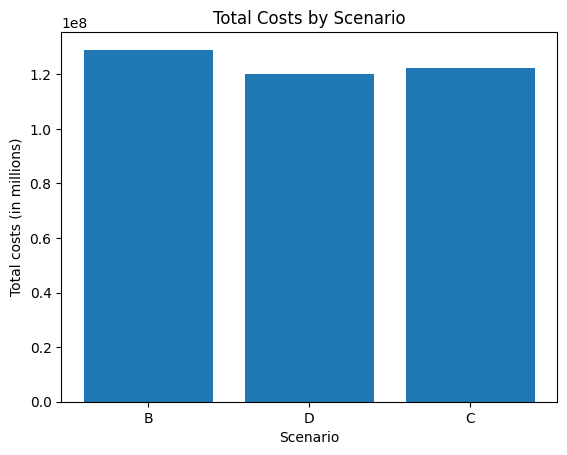

In [29]:

# Data
labels = ['B', 'D', 'C']
total_costs = [results_sum['b_total_costs'], results_sum['d_total_costs'],results_sum['c_total_costs']]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(labels, total_costs)

# Add labels and title
ax.set_xlabel('Scenario')
ax.set_ylabel('Total costs (in millions)')
ax.set_title('Total Costs by Scenario')

plt.show()


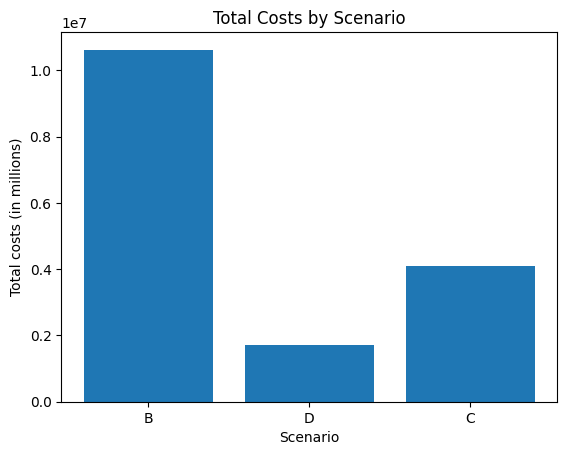

In [30]:
# Data
b_total_costs_sum = results['b_CO2_costs'].sum()
c_total_costs_sum = results['b_CO2_costs'].sum()
c_total_costs_sum = results['b_CO2_costs'].sum()

labels = ['B', 'D', 'C']
total_costs = [results_sum['b_CO2_costs'], results_sum['d_CO2_costs'],results_sum['c_CO2_costs']]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(labels, total_costs)

# Add labels and title
ax.set_xlabel('Scenario')
ax.set_ylabel('Total costs (in millions)')
ax.set_title('Total Costs by Scenario')

plt.show()


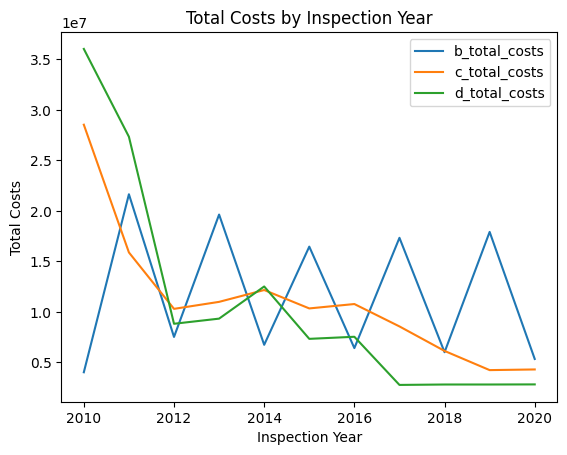

In [31]:
# create the dataframe from the table

total_cost_comparision = pd.DataFrame()

total_cost_comparision['b_total_costs'] = results['b_total_costs']
total_cost_comparision['c_total_costs'] = results['c_total_costs']
total_cost_comparision['d_total_costs'] = results['d_total_costs']


data = {'b_total_costs': total_cost_comparision['b_total_costs'],
        'c_total_costs': total_cost_comparision['c_total_costs'],
        'd_total_costs': total_cost_comparision['d_total_costs']}
df_p = pd.DataFrame(data, index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

# create the figure and axis objects
fig, ax = plt.subplots()

# plot the lines
df_p.plot(ax=ax)

# set the title and axis labels
ax.set_title('Total Costs by Inspection Year')
ax.set_xlabel('Inspection Year')
ax.set_ylabel('Total Costs')

# show the plot
plt.show()


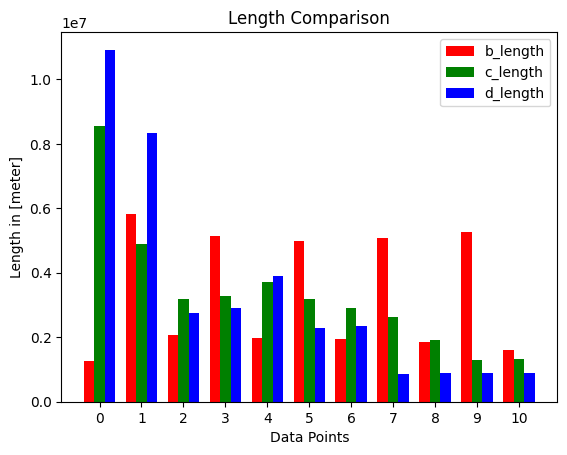

In [ ]:
#comparison of the length inspected per year

results['b_length'] = df.groupby("InspectionYear").sum()["Length"]
results['d_length'] = df.groupby("d_inspection_year").sum()["Length"]
results['c_length'] = df.groupby("c_inspection_year").sum()["Length"]



# Get the data
b_length = results['b_length']
c_length = results['c_length']
d_length = results['d_length']

# Set up the figure and axis
fig, ax = plt.subplots()

# Set the bar width
bar_width = 0.25

# Set the x positions of the bars
x_pos = np.arange(len(b_length))

# Plot the bars
ax.bar(x_pos, b_length, width=bar_width, color='r', align='center', label='b_length')
ax.bar(x_pos + bar_width, c_length, width=bar_width, color='g', align='center', label='c_length')
ax.bar(x_pos + 2*bar_width, d_length, width=bar_width, color='b', align='center', label='d_length')

# Add x-axis tick labels
ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(x_pos)

# Set the axis labels and title
ax.set_xlabel('Data Points')
ax.set_ylabel('Length in [meter]')
ax.set_title('Length Comparison')

# Add a legend
ax.legend()

# Show the plot
plt.show()


<Axes: ylabel='Count'>

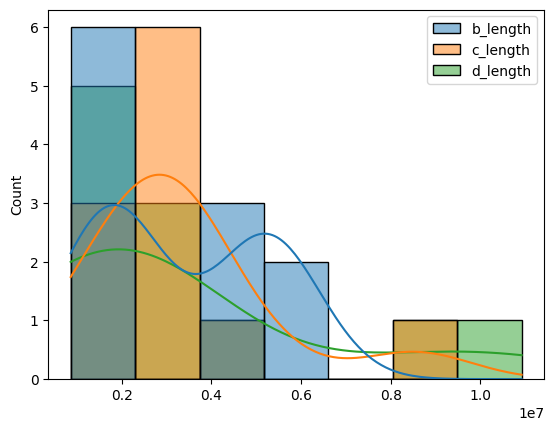

In [ ]:
import seaborn as sns
import scipy.stats as stats


sns.histplot(data=[b_length, c_length, d_length], kde=True)





In [ ]:
efficiency_comparision = pd.DataFrame()

efficiency_comparision['b_timedifference'] = results['b_timedifference']
efficiency_comparision['c_timedifference'] = results['c_timedifference']
efficiency_comparision['d_timedifference'] = results['d_timedifference']

efficiency_comparision

,b_timedifference,c_timedifference,d_timedifference
InspectionYear,,,
2010,682772.0,2.485558e+05,2.582350e+05
2011,3666399.0,5.386350e+05,5.274667e+05
2012,980605.0,9.832250e+05,9.217007e+05
2013,3332779.0,1.506685e+06,1.442463e+06
2014,1104649.0,2.111419e+06,2.130412e+06
2015,3309503.0,2.845010e+06,2.883634e+06
2016,1090624.0,3.673612e+06,3.774247e+06
2017,3401233.0,4.682018e+06,4.788279e+06
2018,1010939.0,5.720402e+06,5.807700e+06


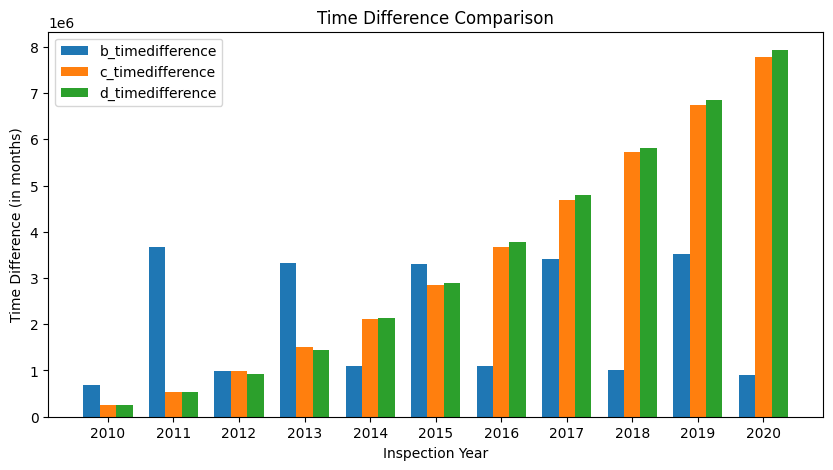

In [ ]:

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10,5))

# create the bar chart
bar_width = 0.25
x_pos = range(len(efficiency_comparision))
ax.bar(x_pos, efficiency_comparision['b_timedifference'], width=bar_width, label='b_timedifference')
ax.bar([x + bar_width for x in x_pos], efficiency_comparision['c_timedifference'], width=bar_width, label='c_timedifference')
ax.bar([x + bar_width*2 for x in x_pos], efficiency_comparision['d_timedifference'], width=bar_width, label='d_timedifference')

# set the x-axis labels and title
ax.set_xticks([x + bar_width for x in x_pos])
ax.set_xticklabels(efficiency_comparision.index)
ax.set_xlabel('Inspection Year')
ax.set_ylabel('Time Difference (in months)')
ax.set_title('Time Difference Comparison')

# set the legend
plt.legend()

# show the chart
plt.show()



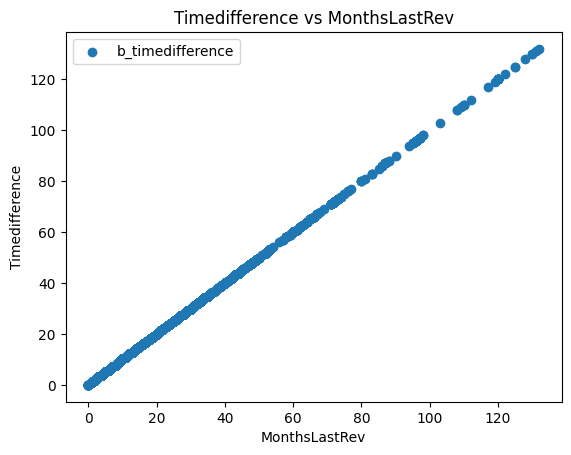

In [ ]:
fig, ax = plt.subplots()

# plot b_timedifference
ax.scatter(df['MonthsLastRev'], df['b_timedifference'], label='b_timedifference', alpha=1)

# plot c_timedifference
#ax.scatter(df['MonthsLastRev'], df['c_timedifference'], label='c_timedifference', alpha=0.5)

# plot d_timedifference
#ax.scatter(df['Mont1qawöäsLastRev'], df['d_timedifference'], label='d_timedifference', alpha=0.5)

# set labels and title
ax.set_xlabel('MonthsLastRev')
ax.set_ylabel('Timedifference')
ax.set_title('Timedifference vs MonthsLastRev')

# set dynamic scale
ax.autoscale(enable=True, axis='both', tight=False)

# add legend
ax.legend()

plt.show()

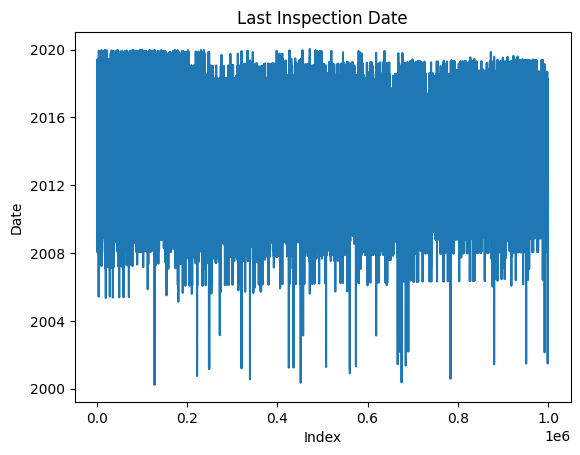

In [ ]:

# assuming the DataFrame is named 'df'
df['LastInspect'].plot(kind='line')

# customize the plot if desired
plt.title('Last Inspection Date')
plt.xlabel('Index')
plt.ylabel('Date')
plt.show()


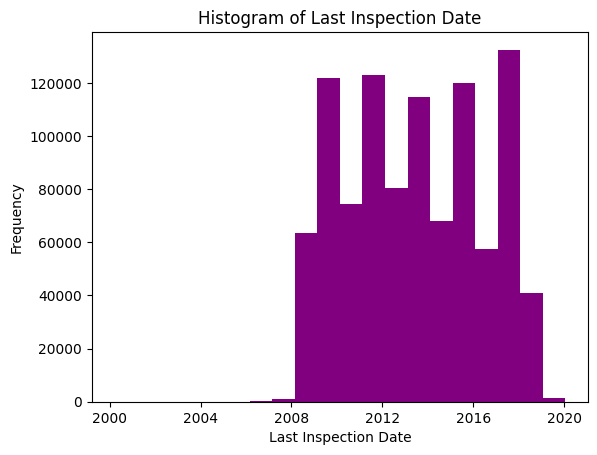

In [ ]:

# create histogram plot
plt.hist(df['LastInspect'], bins=20, color='purple')

# add labels and title
plt.xlabel('Last Inspection Date')
plt.ylabel('Frequency')
plt.title('Histogram of Last Inspection Date')

# show plot
plt.show()


### ==========================================================================
## End of Notebook 2: Inspection Strategy (2/5)
### ==========================================================================